# Video Face Recognition (With FastAI V2)

In [1]:
from fastai2.vision.all import *

## Preparing the data

In [2]:
path = Path('./data/combined')
path

Path('data/combined')

In [3]:
files = get_image_files(path)
len(files)

1811

In [4]:
def label_func(file):
    return file.parent.name

label_func(files[0])

'dahyun'

In [5]:
dls = ImageDataLoaders.from_folder(path, item_tfms=Resize(224), num_workers=0)
print('Number of training images:', len(dls.train_ds.items))
print('Number of valid images:', len(dls.valid_ds.items))

Number of training images: 1480
Number of valid images: 331


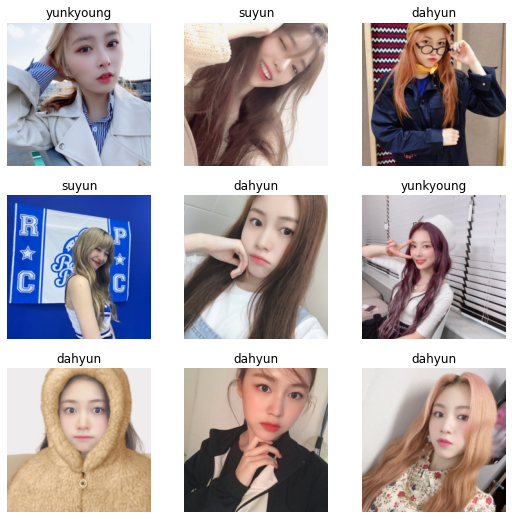

In [6]:
dls.show_batch()

## Train the model

In [7]:
learner = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])
learner.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.230633,1.496686,0.498489,0.501511,01:00


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.995465,1.027219,0.667674,0.332326,01:01


SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=1.3182567499825382e-06)

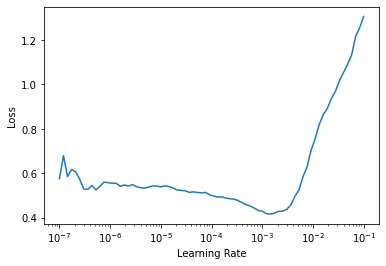

In [8]:
learner.lr_find()

In [9]:
learner.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.528386,0.921049,0.700906,0.299094,00:58


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.330512,0.902685,0.719033,0.280967,01:00
1,0.256520,0.936952,0.728097,0.271903,01:00
2,0.185796,0.892227,0.758308,0.241692,01:00
3,0.131418,0.820652,0.776435,0.223565,00:59
4,0.096315,0.822273,0.776435,0.223565,00:59


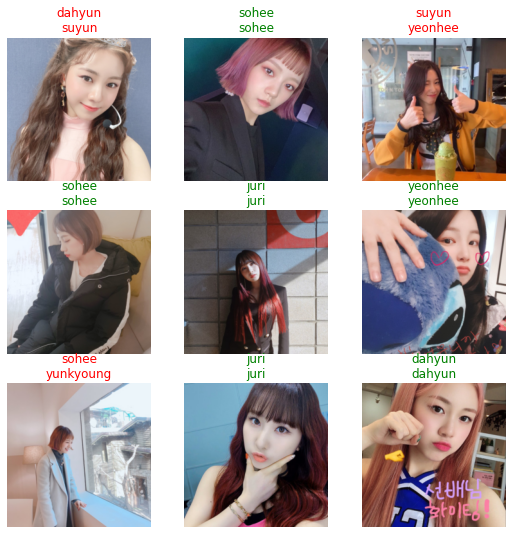

In [10]:
learner.show_results()

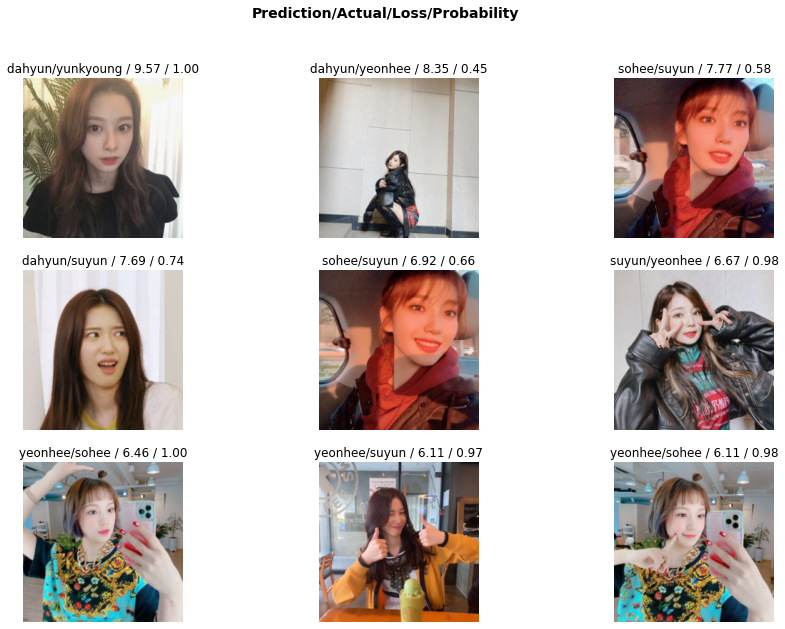

In [11]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(9, figsize=(15,10))

('dahyun',
 tensor(0),
 tensor([9.9998e-01, 6.6745e-06, 9.2322e-07, 4.1590e-06, 2.0587e-06, 3.6804e-06]))

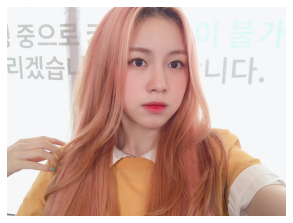

In [12]:
test_img = PILImage.create(files[0])
test_img.show()
learner.predict(files[0])

In [16]:
type(files[0])

pathlib.WindowsPath

## Extract and predict faces

In [20]:
import cv2
import torch
import PIL

In [21]:
test_path = './data/twitter'
test_images = get_image_files(test_path)
len(test_images)

573

In [42]:
def convert_image(im, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = im.resize((size, size))
    img_t = torch.Tensor(np.array(img))
    
    return img_t.permute(2,0,1).float()/255.

In [45]:
idx = 4
test_image = cv2.imread(str(test_images[idx]))
cv2.imshow('test image', test_image)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [61]:
img_copy = test_image.copy()
proto_txt = './data/deploy.prototxt.txt'
caffe_model = './data/weights.caffemodel'

THRESHOLD = 0.5
RESIZE = 224

h, w = test_image.shape[:2]
blob = cv2.dnn.blobFromImage(img_copy, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
face_model = cv2.dnn.readNetFromCaffe(proto_txt, caffe_model)
face_model.setInput(blob)
face_detector = face_model.forward()

if len(face_detector) > 0:
    for i in range(0, face_detector.shape[2]):
        rect = face_detector[0,0,i,3:7] * np.array([w,h,w,h])
        (startX, startY, endX, endY) = rect.astype('int')
        
        confidence = face_detector[0,0,i,2]
        if confidence > THRESHOLD:
            cv2.rectangle(img_copy, (startX, startY), (endX, endY), (255,255,255), 2)
            
            face = img_copy[startY:endY, startX:endX]
            face = cv2.resize(face, (RESIZE, RESIZE))
            face = np.expand_dims(face, axis=0)
            m = 1
            c = 3
            face = np.reshape(face, [m, c, RESIZE, RESIZE])
            face = torch.Tensor(face)
            print(face.shape)
            
            face = face.cuda()
            preds = learner.model(face)
            print()

torch.Size([1, 3, 224, 224])


AttributeError: 'Tensor' object has no attribute 'decodes'